## Import Required Packages

In [81]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import PIL
import datetime
import os
import random
import shutil
import time

## Load Required File Path

In [82]:
all_file = '/.../'
test1_l0 = '/.../'
test2_l0 = '/.../'
test3_l0 = '/.../'
test4_l0 = '/.../'
test5_l0 = '/.../'
test6_l0 = '/.../'

## Compute Image Features from Image Array Parsed from TF Record

In [85]:
def parse_tf(tf_path):
    feature = {'image/height': tf.io.FixedLenFeature([], tf.int64),
               'image/width': tf.io.FixedLenFeature([], tf.int64),
               'image/format': tf.io.FixedLenFeature([], tf.string),
               'image/name': tf.io.FixedLenFeature([], tf.string),
               'image/rescale_factor': tf.io.FixedLenFeature([], tf.int64),
               'image/encoded': tf.io.FixedLenFeature([], tf.string)}

    tfrecord_dataset = tf.data.TFRecordDataset(tf_path)

    def _parse_image_function(key):
        return tf.io.parse_single_example(key, feature)

    pGAN_dataset = tfrecord_dataset.map(_parse_image_function)

    imgs = list()
    patch_name = list()
    for tfrecord_value in pGAN_dataset:
        img = tf.io.decode_image(tfrecord_value['image/encoded'])
        img = img[:, :, :3]   # trim off alpha channel
        imgs.append(img)
        img_name = tfrecord_value['image/name']
        patch_name.append(img_name)
        image_shape = img.shape

    return imgs, patch_name, image_shape

In [86]:
def customize_resnet(input_shape=(512, 512, 3)):
    ## Load the ResNet50 model
    resnet50_model = tf.keras.applications.resnet50.ResNet50(include_top=False,weights='imagenet',input_shape=input_shape)
    resnet50_model.trainable = False  ## Free Training

    ## Create a new Model based on original resnet50 model ended after the 3rd residual block
    layer_name = 'conv4_block1_0_conv'
    res50 = tf.keras.Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer(layer_name).output)

    ## Add adaptive mean-spatial pooling after the new model
    adaptive_mean_spatial_layer = tf.keras.layers.GlobalAvgPool2D()
    
    return res50, adaptive_mean_spatial_layer

In [87]:
def get_img_feature(img_array, res50, adaptive_mean_spatial_layer):
    Image_Features = list()
    for i in range(len(img_array)):
        image_np = np.array(img_array[i])
        image_batch = np.expand_dims(image_np, axis=0)
        image_patch = tf.keras.applications.resnet50.preprocess_input(image_batch.copy())
        predicts = res50.predict(image_patch)
        features = adaptive_mean_spatial_layer(predicts)

        img_features = features.numpy()
        img_features = tf.convert_to_tensor(img_features)
        
        Image_Features.append(img_features)
    
    # preprocessing Image Features to match the required input shape of K Means clustering fit method
    # default shape be (#img_patches, 1024)
    Image_Features_Flat = [tf.reshape(i, (img_features.shape[1], )).numpy() for i in Image_Features]
    Image_Features_Flat = np.array(Image_Features_Flat)
    
    return Image_Features, Image_Features_Flat

In [88]:
imgs_1, patch_name_1, image_shape_1 = parse_tf(test1_l0)
imgs_2, patch_name_2, image_shape_2 = parse_tf(test2_l0)
imgs_3, patch_name_3, image_shape_3 = parse_tf(test3_l0)
imgs_4, patch_name_4, image_shape_4 = parse_tf(test4_l0)
imgs_5, patch_name_5, image_shape_5 = parse_tf(test5_l0)
imgs_6, patch_name_6, image_shape_6 = parse_tf(test6_l0)

In [89]:
res50, adaptive_mean_spatial_layer = customize_resnet(input_shape=image_shape_1)

In [91]:
Image_Features_1, IFF1 = get_img_feature(img_array=imgs_1, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_2, IFF2 = get_img_feature(img_array=imgs_2, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_3, IFF3 = get_img_feature(img_array=imgs_3, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_4, IFF4 = get_img_feature(img_array=imgs_4, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_5, IFF5 = get_img_feature(img_array=imgs_5, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)
Image_Features_6, IFF6 = get_img_feature(img_array=imgs_6, res50=res50, adaptive_mean_spatial_layer=adaptive_mean_spatial_layer)

## Plot Image Feature Distribution

In [101]:
I_feature1 = [tf.reshape(i, (image_shape_1[0], )).numpy() for i in Image_Features_1]

In [123]:
dense_fig_1 = sns.displot(I_feature1)
dense_fig_1.savefig('density Plot 1.png')

## K Means Clustering

In [54]:
def optimize_kmean(x, init_k=2, max_k=10):
    silh_score = list()
    
    for k in range(init_k, max_k+1):
        kmeans = KMeans(n_clusters=k).fit(x)
        labels = kmeans.labels_
        silh = silhouette_score(x, labels, metric='euclidean')
        silh_score.append(silh)
    
    idm_silh = silh_score.index(max(silh_score))
    optim_k = init_k + idm_silh
    
    return silh_score, optim_k

### Test1 - Find Optimized K on 6 SVS Slides at Level 0 in Image Feature Space

In [10]:
silh_score_1, optim_k_1 = optimize_kmean(x=IFF1, init_k=2, max_k=10)
silh_score_2, optim_k_2 = optimize_kmean(x=IFF2, init_k=2, max_k=10)
silh_score_3, optim_k_3 = optimize_kmean(x=IFF3, init_k=2, max_k=10)
silh_score_4, optim_k_4 = optimize_kmean(x=IFF4, init_k=2, max_k=10)
silh_score_5, optim_k_5 = optimize_kmean(x=IFF5, init_k=2, max_k=10)
silh_score_6, optim_k_6 = optimize_kmean(x=IFF6, init_k=2, max_k=10)

### Test2 - PCA -> Optimizing K Inherited Test1 in Image Feature Space

In [125]:
pca = PCA(n_components=10)

In [126]:
pca_c = pca.fit(IFF1)

In [127]:
x = pca_c.components_[0]

In [128]:
y = pca_c.components_[1]

/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Anaconda/conda_env/clam/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


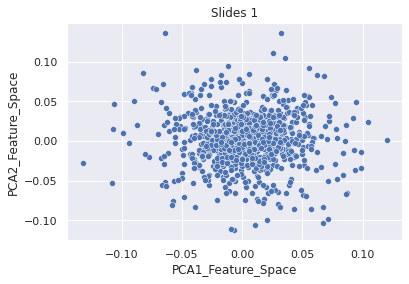

In [130]:
sns.scatterplot(x,y)
plt.title('Slides 1')
plt.xlabel('PCA1_Feature_Space')
plt.ylabel('PCA2_Feature_Space')
plt.savefig('PCA_fs_s1.png')

In [11]:
PCA_F1 = pca.fit_transform(IFF1)
PCA_F2 = pca.fit_transform(IFF2)
PCA_F3 = pca.fit_transform(IFF3)
PCA_F4 = pca.fit_transform(IFF4)
PCA_F5 = pca.fit_transform(IFF5)
PCA_F6 = pca.fit_transform(IFF6)

In [13]:
ss1, ok1 = optimize_kmean(x=PCA_F1, init_k=2, max_k=10)
ss2, ok2 = optimize_kmean(x=PCA_F2, init_k=2, max_k=10)
ss3, ok3 = optimize_kmean(x=PCA_F3, init_k=2, max_k=10)
ss4, ok4 = optimize_kmean(x=PCA_F4, init_k=2, max_k=10)
ss5, ok5 = optimize_kmean(x=PCA_F5, init_k=2, max_k=10)
ss6, ok6 = optimize_kmean(x=PCA_F6, init_k=2, max_k=10)

### Test3 - Optimizing K on 6 SVS Slides at Level 5 (i.e. 32 x 32) in Image Patch Space

In [12]:
test1_l5 = '/.../'
test2_l5 = '/.../'
test3_l5 = '/.../'
test4_l5 = '/.../'
test5_l5 = '/.../'
test6_l5 = '/.../'

In [13]:
imgs1, image_shape1 = parse_tf(test1_l5)
imgs2, image_shape2 = parse_tf(test2_l5)
imgs3, image_shape3 = parse_tf(test3_l5)
imgs4, image_shape4 = parse_tf(test4_l5)
imgs5, image_shape5 = parse_tf(test5_l5)
imgs6, image_shape6 = parse_tf(test6_l5)

In [41]:
new_shape = np.prod(imgs1[0].shape)

In [42]:
def img_reshape(imgs, new_shape):
    imgs = [tf.reshape(i, (new_shape, )).numpy() for i in imgs]
    imgs = np.array(imgs)
    
    return imgs

In [43]:
imgs1 = img_reshape(imgs1, new_shape)
imgs2 = img_reshape(imgs2, new_shape)
imgs3 = img_reshape(imgs3, new_shape)
imgs4 = img_reshape(imgs4, new_shape)
imgs5 = img_reshape(imgs5, new_shape)
imgs6 = img_reshape(imgs6, new_shape)

In [131]:
pca_p = PCA(n_components=10)

In [132]:
pca_pc = pca_p.fit(imgs1)

In [133]:
x = pca_pc.components_[0]
y = pca_pc.components_[1]

/research/bsi/projects/PI/tertiary/Hart_Steven_m087494/s211408.DigitalPathology/Quincy/Anaconda/conda_env/clam/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


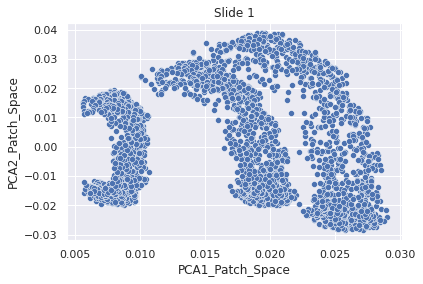

In [134]:
sns.scatterplot(x,y)
plt.title('Slide 1')
plt.xlabel('PCA1_Patch_Space')
plt.ylabel('PCA2_Patch_Space')
plt.savefig('PCA_ps_s1.png')

In [55]:
silh_score_51, optim_k_51 = optimize_kmean(x=imgs1, init_k=2, max_k=10)
silh_score_52, optim_k_52 = optimize_kmean(x=imgs2, init_k=2, max_k=10)
silh_score_53, optim_k_53 = optimize_kmean(x=imgs3, init_k=2, max_k=10)
silh_score_54, optim_k_54 = optimize_kmean(x=imgs4, init_k=2, max_k=10)
silh_score_55, optim_k_55 = optimize_kmean(x=imgs5, init_k=2, max_k=10)
silh_score_56, optim_k_56 = optimize_kmean(x=imgs6, init_k=2, max_k=10)

In [22]:
def ok_clustering(x, optim_k):
    kmean_labels = list()
    kmeans = KMeans(n_clusters=optim_k).fit(x)
    
    for i in kmeans.labels_:
        kmean_labels.append(i)
    
    return kmean_labels

In [25]:
kmean_labels = ok_clustering(x=IFF1, optim_k=optim_k_51)

## Test 4 - Force K=50 for clustering

In [65]:
kmeans_50 = KMeans(n_clusters=50)
kmeans_50.fit(IFF1)

KMeans(n_clusters=50)

In [104]:
patch_id_1 = list()
for i in range(len(IFF1)):
    patch_id_1.append(i)

In [115]:
patch_names_1 = [i.numpy().decode('utf-8') for i in patch_name_1]

In [116]:
cluster_id_1 = list()
for i in kmeans_50.labels_:
    cluster_id_1.append(i)

In [117]:
df_50_1 = pd.DataFrame(list(zip(patch_id_1, patch_names_1, cluster_id_1)),
              columns=['patch_id', 'patch_name', 'cluster_id'])

In [118]:
df_50_1

,patch_id,patch_name,cluster_id
0,0,183533.svs_x_1024_2048_y_5120_6144.png,25
1,1,183533.svs_x_1024_2048_y_6144_7168.png,2
2,2,183533.svs_x_1024_2048_y_9216_10240.png,2
3,3,183533.svs_x_1024_2048_y_10240_11264.png,25
4,4,183533.svs_x_14336_15360_y_10240_11264.png,5
...,...,...,...
1871,1871,183533.svs_x_154624_155648_y_44032_45056.png,46
1872,1872,183533.svs_x_154624_155648_y_45056_46080.png,34
1873,1873,183533.svs_x_154624_155648_y_46080_47104.png,46
1874,1874,183533.svs_x_154624_155648_y_47104_48128.png,7


In [119]:
df_50_1.to_csv('k_50_1_clustering.txt', sep='\t', index=False)

In [181]:
patch_path = '/.../'

In [182]:
dest_path = '/.../'

In [204]:
def clustering_check(patch_path, dest_path):
    for i in range(50):
        for j in df_50_1['cluster_id']:
            if j == i:
                for k in pd.DataFrame(df_50_1['patch_id'][df_50_1['cluster_id'] == j])['patch_id']:
                    name = os.listdir(patch_path)[k]
                    file = os.path.join(patch_path, name)
                    dest_dir = os.path.join(dest_path, 'Cluster_' + str(j))
                    if os.path.exists(dest_dir) == False:
                        os.mkdir(os.path.join(dest_path, 'Cluster_' + str(j)))
                    shutil.copy(file, dest_dir)

In [205]:
clustering_check(patch_path=patch_path, dest_path=dest_path)